In [3]:
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [4]:
loader = DirectoryLoader('./', glob="./data/*.txt", loader_cls=TextLoader)
docs = loader.load()

In [5]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vectors = embeddings.embed_documents(doc_strings)

In [7]:
db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 6})

In [8]:
import umap
import numpy as np
from tqdm import tqdm

# Transform the vectors to 2D space in order to visualize them
umap_transformer = umap.UMAP(random_state=0, transform_seed=0).fit(vectors)

/Users/ttornkvi/git/Applied-Advanced-RAG/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ttornkvi/git/Applied-Advanced-RAG/venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [9]:
def umap_embed(vectors, umap_transformer):
    umap_embeddings = np.array([umap_transformer.transform([vector])[0] for vector in tqdm(vectors)])
    return umap_embeddings

In [10]:
global_embeddings = umap_embed(vectors, umap_transformer)

100%|██████████| 63/63 [00:20<00:00,  3.13it/s]


In [11]:
global_embeddings

array([[ 7.350314  ,  8.702798  ],
       [ 8.869891  ,  9.039424  ],
       [ 7.1216836 ,  8.476796  ],
       [ 8.343831  ,  5.362691  ],
       [ 7.1659813 ,  7.5243745 ],
       [ 6.962714  ,  7.804892  ],
       [ 9.157101  ,  5.8796573 ],
       [ 9.222268  ,  7.595507  ],
       [ 9.417045  ,  7.1369457 ],
       [ 7.570833  ,  7.0963664 ],
       [ 7.0411706 ,  8.384525  ],
       [ 7.554728  ,  5.395637  ],
       [ 6.8335967 ,  6.0773005 ],
       [ 7.544265  ,  5.3743706 ],
       [ 7.073204  ,  7.6377435 ],
       [ 9.431235  ,  7.0119    ],
       [ 9.456773  ,  6.463598  ],
       [ 9.178359  ,  5.9195504 ],
       [ 8.479376  ,  5.3272743 ],
       [ 6.944905  ,  8.112816  ],
       [ 6.846789  ,  6.983943  ],
       [ 6.8396482 ,  6.1947746 ],
       [ 7.562661  ,  8.83229   ],
       [ 6.8113494 ,  6.3894453 ],
       [ 7.4709496 ,  8.762698  ],
       [ 7.793986  ,  8.9658    ],
       [ 9.11626   ,  8.78858   ],
       [ 7.6939945 ,  8.89767   ],
       [ 7.6861086 ,

(6.202728819847107, 19.592381405830384, 0.26535394489765163, 9.45723679959774)

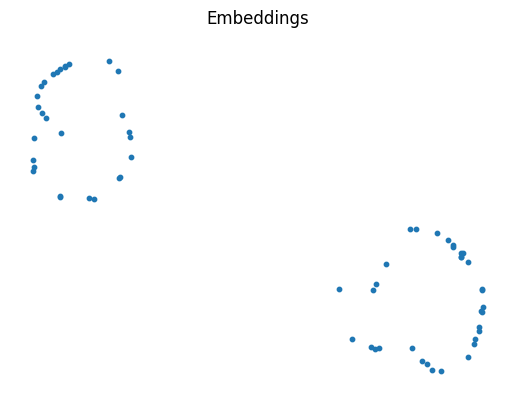

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Embeddings')
plt.axis('off')

In [13]:
def calc_global_embeddings(query, embeddings, retriever, umap_transformer, embed_function, global_embeddings):
    q_embedding = embeddings.embed_query(query)

    docs = retriever.get_relevant_documents(query)
    page_contents = [doc.page_content for doc in docs]
    vectors_content_vectors = embeddings.embed_documents(page_contents)

    query_embeddings = embed_function([q_embedding], umap_transformer)
    retrieved_embeddings = embed_function(vectors_content_vectors, umap_transformer)

    plt.figure()
    plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10, color='gray')
    plt.scatter(query_embeddings[:, 0], query_embeddings[:, 1], s=150, marker='X', color='r')
    plt.scatter(retrieved_embeddings[:, 0], retrieved_embeddings[:, 1], s=50, facecolors='none', edgecolors='g')
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{query}')
    plt.axis('off')
    plt.show()


/var/folders/cq/lhlr_ykn5l123vlq84c24fvm0000gn/T/ipykernel_6661/3242896288.py:4: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  docs = retriever.get_relevant_documents(query)
100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


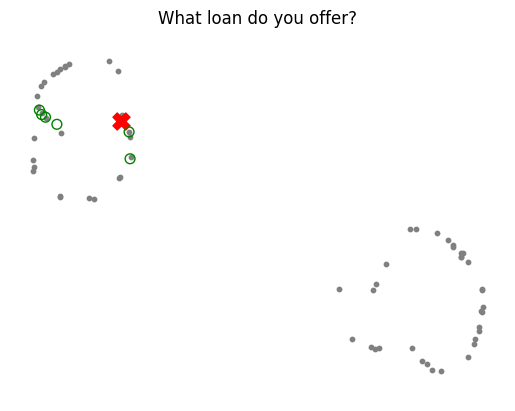

In [14]:
calc_global_embeddings("What loan do you offer?", embeddings, retriever, umap_transformer, umap_embed, global_embeddings)

100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


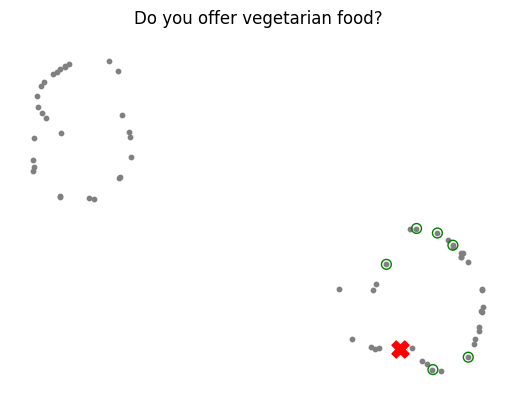

In [15]:
calc_global_embeddings("Do you offer vegetarian food?", embeddings, retriever, umap_transformer, umap_embed, global_embeddings)


### Query Expansion 

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
        temperature=0,
        max_tokens=800,
        #model_kwargs={"top_p": 0, "frequency_penalty": 0, "presence_penalty": 0},
        top_p=0,
        frequency_penalty=0,
        presence_penalty=0
    )

In [7]:
from langchain.schema.runnable import Runnable
from langchain_core.messages.ai import AIMessage

# Experiment with a Runnable that can convert a (list of) AIMessage objects to a list of strings
class AIMessageToString(Runnable):
    def invoke(self, input_messages, config):
        # Check if input_messages is a list
        if isinstance(input_messages, list):
            # Initialize an empty list to store content strings
            content_strings = []
            # Loop over each message in the list
            for message in input_messages:
                # Check if the message is a AIMessages instance
                if isinstance(message, AIMessage):
                    # Append the content string to the list
                    content_strings.append(message.content)
                else:
                    raise TypeError("Expected each item in the list to be a AIMessage object.")
            # Return the list of content strings
            return content_strings
        else:
            # Check if the message is just an AIMessages instance
            if isinstance(input_messages, AIMessage):
                # Return the content string
                return input_messages.content
            else:
                raise TypeError("Expected input_message to be a AIMessage object.")

In [8]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda

query = "Do you offer vegetarian food?"

def split_lines(text: str) -> list[str]:
    return text.strip().split("\n")

output_parser = AIMessageToString() | RunnableLambda(split_lines)

prompt = ChatPromptTemplate.from_template(
    """You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    Provide these alternative questions separated by newlines. Only provide the query, no numbering.
    Original question: {question}""")

llm_chain = prompt | llm | output_parser
queries = llm_chain.invoke(query)
queries

['Do you have vegetarian options available?',
 'Are there vegetarian meal choices on the menu?',
 'Can I find vegetarian dishes at your establishment?',
 'Do you cater to customers looking for vegetarian food?',
 'Is vegetarian food part of your menu offerings?']

In [ ]:
queries = queries.get("text")
queries

In [ ]:
docs = [retriever.get_relevant_documents(query) for query in queries]

In [ ]:
unique_contents = set()
unique_docs = []
for sublist in docs:
    for doc in sublist:
        if doc.page_content not in unique_contents:
            unique_docs.append(doc)
            unique_contents.add(doc.page_content)
unique_contents = list(unique_contents)

In [ ]:
unique_contents

# Cross-encoder re-ranking

In [ ]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [ ]:
pairs = []
for doc in unique_contents:
    pairs.append([query, doc])

In [ ]:
scores = cross_encoder.predict(pairs)
scores

In [ ]:
scored_docs = zip(scores, unique_contents)
sorted_docs = sorted(scored_docs, reverse=True)
sorted_docs

In [ ]:
reranked_docs = [doc for _, doc in sorted_docs][0:8]
reranked_docs

### Lost in the middle Problem

In [ ]:
from langchain_community.document_transformers import (
    LongContextReorder
)

In [ ]:
reordering = LongContextReorder()
reordered_docs = reordering.transform_documents(reranked_docs)
reordered_docs